In [1]:
import math
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import quad, dblquad
import sys
sys.path.insert(1, '/Users/samuelwitte/Desktop/Magnetized_Plasma/Axion_Infall/src')
from AMC_Density_Evolution import *
import glob
import healpy as hp
import os
from scipy.stats import poisson
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
from mpl_toolkits import mplot3d
from matplotlib import ticker
from matplotlib.patches import Rectangle


from matplotlib import rc
rc('text', usetex=True)
mpl.rcParams['axes.formatter.use_mathtext']=True
mpl.rcParams['figure.dpi']=90
wid=1.3
mpl.rcParams['axes.linewidth'] = wid #set the value globally
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Times']

mpl.rcParams['font.weight'] = 2.0


In [2]:

def tele_details(tele_name):
    if tele_name == 'SKA-Mid':
        dsize = 15
        ndish = 5659
        T_rec = 20
        eta_coll = 0.8
        fname = '_SKA_Mid_'
    elif tele_name == 'SKA-Low':
        dsize = 35
        ndish = 1000
        T_rec = 40
        eta_coll = 0.8
        fname = '_SKA_Low_'
    elif tele_name == 'Hirax':
        dsize = 6
        T_rec = 50
        ndish = 1024
        eta_coll = 0.6
        fname = '_Hirax_'
        
    elif tele_name == 'GBT':
        dsize = 100
        T_rec = 20
        ndish = 1
        eta_coll = 0.7
        fname = '_GBT_'
    else:
        print('Telescope not included...')
        return
    return dsize, ndish, T_rec, eta_coll, fname


def fwhm_radio(mass_a, dsize=15): # dsize in m
    freq = mass_a / (2*np.pi) / 6.58e-16 / 1e9 # GHz
    fwhm = 0.7 * (1 / freq) * (15 / dsize)
    return fwhm # deg
    
def fov_suppression(ang_dist, mass_a, dsize=15):
    FWHM = fwhm_radio(mass_a, dsize=dsize)
    Sense_StdDev = FWHM / 2.355
    suppress_F = np.exp(- ang_dist**2 / (2 * Sense_StdDev**2)) / (Sense_StdDev * np.sqrt(2*np.pi))
    return suppress_F

def sense_compute(mass, bwidth=1e-3, t_obs=1, SNR=5, SEFD=None):
    # t_obs days, bwidth fractional
    if SEFD is None:
        SEFD = 0.098*1e3 #mJy
    
    return SNR * SEFD / np.sqrt(2 * mass * bwidth * t_obs * 24 * 60**2 / 6.58e-16)


def SEFD_tele(mass, dsize=15, ndish=2000, T_rec=20, eta_coll=0.8):
    Aeff = np.pi * (dsize / 2)**2 * ndish * eta_coll * (1e2)**2 # cm ^2
    #skyT = sky_temp(mass, dsize=dsize)
    #T_tot = skyT + T_rec # K
    T_tot = T_rec # K
    SEFD = 2 * T_tot / Aeff * 1.38e-16 / 1e-23 * 1e3 # mJy
    # print('Freq [GHz]: {:.2e}, Sky Temp [K]: {:.2e}, SEFD [Jy]: {:.2e}'.format(mass / (2*np.pi) / 6.58e-16 / 1e9, skyT, SEFD * 1e-3))
    return SEFD

def get_cmap(n, name='tab20'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

In [4]:
def Time_Ftransient(NFW=False, NS_filename='', mass=1e-5, nside=8, t_obs=1, bwidth=2e-5, dsize=15, 
                    ndish=2000, T_rec=20, eta_coll=0.8, tele_tag='', fov_hit=True, fileTag='', 
                    Time_int=365, enc_rate=1, andromeda=True, sve=False):
    
    bw_norm = 92e3 # Hz
    bwidth = bw_norm / mass * (2*np.pi) * 6.58e-16
        
    lwall = 1
    # t_obs in days, Time_int [days], enc_rate [#/day]
    if enc_rate**-1 > Time_int:
        print('Encounter rate too small! Increase Time_int')
        return
    
    t_bin_center = Time_int / 2

    orig_F = np.loadtxt('../encounter_data/'+NS_filename)
    sefd_list = SEFD_tele(mass, dsize=dsize, ndish=ndish, T_rec=T_rec, eta_coll=eta_coll)
    
    files = glob.glob('results/Minicluster_PeriodAvg*')
    
    avgN_events = (enc_rate * Time_int)
    print('Avg number of events: {:.0f}'.format(avgN_events))
#     if avgN_events > len(files):
#         print('Not enough files generated, reduce Time_int')
#         return
    
    
    

    Nevts = poisson.rvs(avgN_events)
    NSs = np.random.randint(0,high=len(files)-1,size=Nevts)
    print('drawn events {:.0f}'.format(Nevts))
        
    
    fig, ax = plt.subplots(1, figsize=(8,5))
    ax.set_yscale('log') 
    ax.set_xlim([0, t_obs*24.1])
    
    fs = 16
    ax.tick_params(direction='in', length=8, width=1, labelsize=16)#, colors='r',grid_color='r', grid_alpha=0.5)
    ax.tick_params(which='minor', direction='in', length=6, width=1, labelsize=12) 
    ax.tick_params(axis='y',which='major', length = 10, labelsize = 16, pad=3)
    ax.tick_params(axis='y',which='minor', length = 5, labelsize = 16)
    ax.tick_params(axis='x',which='major', length = 10, labelsize = 16, pad=5.5)
    ax.tick_params(axis='x',which='minor', length = 5, labelsize = 16)
    ax.set_xlabel(r"Time   [hours]", fontsize=fs)
    ax.set_ylabel(r"Flux   [Jy]", fontsize=fs)
    
    ymin = 1e-5
    
    ymax = 1e-100
    # cycle through output files
    # print(NSs)
    freq_list = []
    height_list = []
    clistH = []
    cmap = get_cmap(len(NSs))

    
    for i in range(len(NSs)):
        # identify NS in original file
        find1 = files[NSs[i]].find('_rotPulsar_')
        find2 = files[NSs[i]].find('_B0_')
        periodN = (2 * np.pi) / float(files[NSs[i]][find1+len('_rotPulsar_'):find2])

        find1 = files[NSs[i]].find('_B0_')
        find2 = files[NSs[i]].find('_rNS_')
        B0 = float(files[NSs[i]][find1+len('_B0_'):find2])

        possible = np.where(np.round(orig_F[:,7] / B0, 3) == 1)[0]
        holdI = np.where(np.round(orig_F[:, 6][possible] / periodN, 3) == 1)[0]
        if len(holdI) != 0:
            if len(holdI) > 1:
                # print('Need to FIX!', holdI)
                NSIndx = possible[[holdI[0]]]
                # print(NSIndx)
            else:
                NSIndx = possible[holdI]
        else:
            print('index failure...???', holdI)
            print(files[NSs[i]])
            print(possible)
            print(periodN, B0, orig_F[:, 6][possible], orig_F[:, 7][possible], np.round(orig_F[:,7][possible] / B0, 2))
            return

        # dist = orig_F[NSIndx, 0] # pc
        if andromeda:
            dist = 765.0 * 1e3 # pc
            dist_cen = orig_F[NSIndx, 0]  - 8.5e3 # pc
        else:
            dist = orig_F[NSIndx, 0] # pc
            
        glong = orig_F[NSIndx, 1]
        glat = orig_F[NSIndx, 2]
        dens_amc = orig_F[NSIndx, 3] # M/pc^3
        rad_amc = orig_F[NSIndx, 4] # pc
        bparam = orig_F[NSIndx, 5] # pc
        vel = orig_F[NSIndx, -1] * 3.086*10**13 / 2.998e5 # unitless
        dens_amc *= 3.8 * 10**10 # eV/cm^3
        rad_amc *= 3.086*10**13 # km
        bparam *= 3.086*10**13 # km
        
        
        # compute flux density
        file_in = np.load(files[NSs[i]])
        Theta = file_in[:,2]
        Phi = file_in[:,3]

        pixel_indices = hp.ang2pix(nside, Theta, Phi)
        indxs = hp.nside2npix(nside)
        viewA = int(np.random.rand(1) * indxs)
        rel_rows = file_in[pixel_indices == viewA]
        if len(rel_rows[:,0]) == 0 or np.sum(rel_rows[:, 5]) == 0:
            #print('Rate is 0...', rel_rows[:, 5])
            continue
            
        b_low = np.percentile(rel_rows[:,6], 10)
        b_high = np.percentile(rel_rows[:,6], 90)
       
        bins = np.linspace(b_low, b_high, 5000)
        rate_hold = np.zeros_like(bins)
        for kk in range(len(bins)):
            rate_hold[kk] = np.sum(rel_rows[np.abs(bins[kk] - rel_rows[:,6]) <= (bwidth / 2), 5]) / hp.pixelfunc.nside2resol(nside) # missing rho [eV / cm^3], will be in [eV / s]
        peakF = bins[np.argmax(rate_hold)]
        rate_temp = rate_hold[np.argmax(rate_hold)]
        
        # time analysis....
        # sample peak time
        t_mid = Transient_Time(bparam, rad_amc, vel) / 2
        peakT = np.random.rand() * Time_int
        t0 = peakT - t_mid / (60**2 * 24) # days
        t_min = t_bin_center - t_obs / 2 # days
        t_max = t_bin_center + t_obs / 2 # days

        # print(' \t Start time and peak time of event: {:.2f} and {:.2f}. Transit time: {:.2f}'.format(t0[0], peakT, t_mid[0] / (60**2 * 24) * 2))
        tlist = np.linspace(t_min - t0, t_max - t0, 200) * (60**2 * 24) # seconds
        time_plt = np.linspace(0, t_obs, 200) * 24 # hours
        
        dense_scan = np.zeros_like(tlist)
        for j in range(len(tlist)):
            # print(bparam, rad_amc, dens_amc, vel, tlist[j])
            dense_scan[j] = Transient_AMC_DensityEval(bparam, rad_amc, dens_amc, vel, tlist[j], nfw=NFW)[0]
                 
        #bw_norm = mass * bwidth / (2*np.pi) / 6.58e-16 # Hz
        
        rate_temp *= dense_scan.flatten() / (dist * 3.086*10**18)**2 * 1.6022e-12 / bw_norm * 1e23 # Jy
        rate_temp *= (0.015744)**2 # KSVZ AXION SUPPRESSION FOR 41 mu eV MASS!
        
        if not andromeda:
            ang_dist = np.sqrt(glat**2 + glong**2) # deg
        else:
            ang_dist = np.arctan(dist_cen * np.sin(glat) / (765.0 * 1e3)) * 180 / np.pi # deg

        fovS = fov_suppression(ang_dist, mass, dsize=dsize)
        if fov_hit:
            rate_temp *= fovS
            
        # print(np.sum(rate_temp))
        find1 = files[NSs[i]].find('_NS_Mag_')+len('_NS_Mag_')
        find2 = files[NSs[i]].find('_NS_Theta_')
        NS_mag = float(files[NSs[i]][find1:find2])
        find1 = files[NSs[i]].find('_NS_Theta_')+len('_NS_Theta_')
        find2 = files[NSs[i]].find('__.npz')
        NS_theta = float(files[NSs[i]][find1:find2])
        NS_phi = np.random.rand()*2*np.pi
        
        NS_vx = NS_mag * np.cos(NS_phi) * np.sin(NS_theta)
        NS_vy = NS_mag * np.sin(NS_phi) * np.sin(NS_theta)
        NS_vz = NS_mag * np.cos(NS_theta)
        
        v_los = -np.dot(np.array([NS_vx, NS_vy, NS_vz]), np.array([0,0,1])) 
        vmag = np.sqrt(np.sum(np.array([NS_vx, NS_vy, NS_vz])**2))
        doppler_shift = np.sqrt((1 - v_los) / (1 + v_los))
        
        omeG = mass * (rel_rows[:,6] + 1)
        E_dist = omeG * doppler_shift / (2*np.pi) / 6.58e-16 / 1e9 #/ mass - 1
        
        if rate_temp[0] == 0:
            plt_1v = True
        else:
            plt_1v = False
        if rate_temp[-1] == 0:
            plt_2v = True
        else:
            plt_2v = False
        time_plt = time_plt[rate_temp > 0]
        if len(time_plt) == 0:
            continue
        rate_temp = rate_temp[rate_temp > 0]
        
        if plt_1v:
            plt.vlines(time_plt[0], 1e-100, rate_temp[0], colors='k', linestyles=':', lw=lwall/2)
        if plt_2v:
            plt.vlines(time_plt[-1], 1e-100, rate_temp[-1], colors='k', linestyles=':', lw=lwall/2)
        plt.plot(time_plt, rate_temp, lw=lwall, color=cmap(i))
        
        if time_plt[0] < 2:
            freq_list.append(E_dist)
            den_hold = dense_scan.flatten()
            den_short = den_hold[den_hold > 0][time_plt<2]
            t_short = time_plt[time_plt<2]
            
            rateNew = fovS * rel_rows[:,5] * np.trapz(den_short, t_short) / 2.0 / (dist * 3.086*10**18)**2 * 1.6022e-12 / bw_norm * 1e26 /1e3 / hp.pixelfunc.nside2resol(nside)
            height_list.append(rateNew)
            clistH.append(i)
        
        if np.max(rate_temp) * 5 > ymax :
            ymax = np.max(rate_temp) * 5
#         if np.min(rate_temp) < ymin:
#             ymin = np.min(rate_temp) / 5
    for i in range(5):
        ax.axvspan(i*24, i*24+1.5, alpha=0.3, color='black')

    ax.set_ylim([ymin, ymax])
    #ax.text(87, ymax/5, r'$g_{a\gamma\gamma} = 10^{-12} \, {\rm GeV}^{-1}$', ha='left', fontsize=14);
    ax.text(74, ymax/5, r'Shown: $25\%$ of Encounters', ha='left', fontsize=14);
    #plt.plot(np.array([0, 120]), np.array([1.18e-3, 1.18e-3]), c='red')
    plt.fill_between(np.array([0, 120]), np.array([1.18e-3, 1.18e-3]), color='red', alpha=0.2)
    
    left, bottom, width, height = [0.47, 0.235, 0.4, 0.2]
    rect = Rectangle((50,1.4e-5),68,1e-2,linewidth=1,edgecolor='None',facecolor='w', alpha=0.75)
    ax.add_patch(rect)
    ax2 = fig.add_axes([left, bottom, width, height])
    
    # fig, ax = plt.subplots(1, figsize=(8,2.5))
    ax2.tick_params(direction='in', length=8, width=1, labelsize=12)#, colors='r',grid_color='r', grid_alpha=0.5)
    ax2.tick_params(which='minor', direction='in', length=6, width=1, labelsize=10) 
    ax2.tick_params(axis='y',which='major', length = 0, labelsize = 16, pad=3)
    ax2.tick_params(axis='y',which='minor', length = 0, labelsize = 16)
    ax2.tick_params(axis='x',which='major', length = 10, labelsize = 12, pad=5.5)
    ax2.tick_params(axis='x',which='minor', length = 5, labelsize = 12)
   
    #ax.set_xlabel(r"$(\omega - m_a) / m_a$", fontsize=fs)

    ax2.set_xlabel(r"Freq.  [GHz]", fontsize=12 )#backgroundcolor='w')
    # ax2.set_ylabel(r"Flux   [Jy]", fontsize=fs)
    ax2.set_yscale('log') 
    #freq_space = 5e-6 * mass / (2*np.pi) / 6.58e-16 / 1e9
    freq_space = bw_norm / 1e9
    #bin_up = 5e-6 * mass / (2*np.pi) / 6.58e-16
    
    tickL_maj = [10.03, 10.04, 10.05, 10.06, 10.07]
    tickL_min = [10.0325, 10.035, 10.0375, 10.0425, 10.045, 10.0475, 10.0525, 10.055, 10.0575, 10.0625, 10.065, 10.0675] 
    tickL = ['10.03', '10.04', '10.05', '10.06', '10.07']
    ax2.set_xticks(tickL_maj, minor=False)
    ax2.set_xticklabels(tickL)
    ax2.set_xticks(tickL_min, minor=True)
    #ax2.set_yticks([], minor=False)
    #ax2.set_yticks([], minor=True)
    ax2.set_yticklabels([])
    xmin = 10.04 / 1.0001
    xmax = 10.06 * 1.0001
    ymax=1e-5
    
    for i in range(len(freq_list)):
        # print(i, np.shape(freq_list[i]), np.shape(bins), np.shape(height_list[i]))
        if len(freq_list[i]) <=2:
            continue
        bins = np.arange(np.min(freq_list[i]), np.max(freq_list[i]), freq_space)
        
        plt.hist(freq_list[i], bins=bins, weights=height_list[i], histtype='step', color=cmap(clistH[i]))
        if np.max(freq_list[i]) > xmax:
            xmax = np.max(freq_list[i])*1.0005
        if np.min(freq_list[i]) < xmin:
            xmin = np.min(freq_list[i])/1.0005
            
        if np.max(height_list[i]) > ymax:
            ymax = np.max(height_list[i])
            
    ax2.set_xlim([xmin, xmax])
    ax2.text(xmin * 1.0001, ymax/40, r'$t \in [0, 2]$ \, hr.', ha='left', fontsize=13);
    plt.setp(ax2.spines.values(), linewidth=1)
    ax2.set_ylim([ymin, ymax*2])

    if sve:
        fig.savefig("/Users/samuelwitte/Desktop/TimeEvol_Trans.png", dpi=200)

Avg number of events: 97
drawn events 85


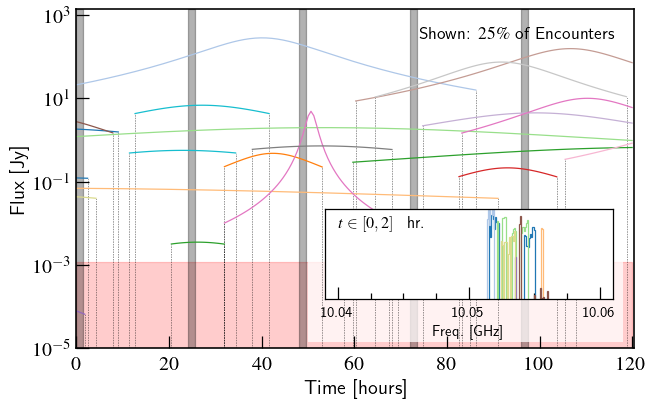

In [6]:
NFW = False
nside = 8
t_obs = 5 # 0.416 # days
bwidth = 1# 5e-6 -- actually ive hard coded it to 96 kHz
tele_name = 'GBT' # SKA-Mid, SKA-Low, Hirax, GBT
ax_mass = 4.1564e-5 # eV
NS_filename = 'Interaction_params_SJW_PL_AScut_ma_41_564mueV_delta_a.txt' #'Interaction_params_SJW_PL_AScut_ma_41_564mueV_delta_a.txt'
fov_hit = True # apply FoV suppression of rate...
fileTag = '_'

Time_int = 10 # time interval [days]
enc_rate = 967.4 * 4e-2 * 0.25 # events / day
sve=True


dsize, ndish, T_rec, eta_coll, tele_tag = tele_details(tele_name)
Time_Ftransient(NFW=NFW, NS_filename=NS_filename, mass=ax_mass, nside=nside, t_obs=t_obs, bwidth=bwidth, 
                dsize=dsize, ndish=ndish, T_rec=T_rec, eta_coll=eta_coll, tele_tag=tele_tag, fov_hit=fov_hit, 
                fileTag=fileTag, Time_int=Time_int, enc_rate=enc_rate, sve=sve)

In [163]:
967.4 * (140/1e3) 

135.436

In [166]:
967.4 * 0.019

18.380599999999998

In [173]:
10 * 20

200

In [176]:
fullF = np.loadtxt('../encounter_data/Interaction_params_SJW_PL_AScut_ma_41_564mueV_delta_a.txt')
vel = fullF[:, -1] * 3.086*10**13 / 2.998e5 # unitless
rad_amc = fullF[:, 4] * 3.086*10**13 # km
bparam = fullF[:, 5] * 3.086*10**13 # km
tmm = []
for i in range(len(fullF[:,0])):
    tmm.append(Transient_Time(bparam[i], rad_amc[i], vel[i])/ (60**2 * 24) )
    

In [179]:
print(np.median(tmm), np.mean(tmm))

1.5566306704705926 2.551730004609531


In [185]:
18.4*1.55

28.52

In [218]:
def MeanNevnts(ggS, rounds=50, NFW=False, NS_filename='', mass=1e-5, nside=8, t_obs=1, bwidth=2e-5, dsize=15, 
                    ndish=2000, T_rec=20, eta_coll=0.8, tele_tag='', fov_hit=True, fileTag='', 
                    Time_int=365, enc_rate=1, andromeda=True, sve=False):
    
    bw_norm = 92e3 # Hz
    bwidth = bw_norm / mass * (2*np.pi) * 6.58e-16
        
    lwall = 1
    # t_obs in days, Time_int [days], enc_rate [#/day]
    if enc_rate**-1 > Time_int:
        print('Encounter rate too small! Increase Time_int')
        return
    
    t_bin_center = Time_int / 2

    orig_F = np.loadtxt('../encounter_data/'+NS_filename)
    sefd_list = SEFD_tele(mass, dsize=dsize, ndish=ndish, T_rec=T_rec, eta_coll=eta_coll)
    
    files = glob.glob('results/Minicluster_PeriodAvg*')
    
    avgN_events = (enc_rate * Time_int)
    print('Avg number of events: {:.0f}'.format(avgN_events))
#     if avgN_events > len(files):
#         print('Not enough files generated, reduce Time_int')
#         return
    
    t_start_obs = [0, 24, 48, 72, 96]
    t_end_obs = [2, 26, 50, 74, 98]
    

    Nevts = poisson.rvs(avgN_events)
    NSs = np.random.randint(0,high=len(files)-1,size=Nevts)
    print('drawn events {:.0f}'.format(Nevts))
        
    

    
    ymin = 1e-5
    
    ymax = 1e-100
    # cycle through output files
    # print(NSs)
    freq_list = []
    height_list = []
    clistH = []
    cmap = get_cmap(len(NSs))
    numRnds = 0
    cnt_hold = []
    while numRnds < rounds:
        cnt_obs = 0

        for i in range(len(NSs)):
            # identify NS in original file
            find1 = files[NSs[i]].find('_rotPulsar_')
            find2 = files[NSs[i]].find('_B0_')
            periodN = (2 * np.pi) / float(files[NSs[i]][find1+len('_rotPulsar_'):find2])

            find1 = files[NSs[i]].find('_B0_')
            find2 = files[NSs[i]].find('_rNS_')
            B0 = float(files[NSs[i]][find1+len('_B0_'):find2])

            possible = np.where(np.round(orig_F[:,7] / B0, 3) == 1)[0]
            holdI = np.where(np.round(orig_F[:, 6][possible] / periodN, 3) == 1)[0]
            if len(holdI) != 0:
                if len(holdI) > 1:
                    # print('Need to FIX!', holdI)
                    NSIndx = possible[[holdI[0]]]
                    # print(NSIndx)
                else:
                    NSIndx = possible[holdI]
            else:
                print('index failure...???', holdI)
                print(files[NSs[i]])
                print(possible)
                print(periodN, B0, orig_F[:, 6][possible], orig_F[:, 7][possible], np.round(orig_F[:,7][possible] / B0, 2))
                return

            # dist = orig_F[NSIndx, 0] # pc
            if andromeda:
                dist = 765.0 * 1e3 # pc
                dist_cen = orig_F[NSIndx, 0]  - 8.5e3 # pc
            else:
                dist = orig_F[NSIndx, 0] # pc

            glong = orig_F[NSIndx, 1]
            glat = orig_F[NSIndx, 2]
            dens_amc = orig_F[NSIndx, 3] # M/pc^3
            rad_amc = orig_F[NSIndx, 4] # pc
            bparam = orig_F[NSIndx, 5] # pc
            vel = orig_F[NSIndx, -1] * 3.086*10**13 / 2.998e5 # unitless
            dens_amc *= 3.8 * 10**10 # eV/cm^3
            rad_amc *= 3.086*10**13 # km
            bparam *= 3.086*10**13 # km


            # compute flux density
            file_in = np.load(files[NSs[i]])
            Theta = file_in[:,2]
            Phi = file_in[:,3]

            pixel_indices = hp.ang2pix(nside, Theta, Phi)
            indxs = hp.nside2npix(nside)
            viewA = int(np.random.rand(1) * indxs)
            rel_rows = file_in[pixel_indices == viewA]
            if len(rel_rows[:,0]) == 0 or np.sum(rel_rows[:, 5]) == 0:
                #print('Rate is 0...', rel_rows[:, 5])
                continue

            b_low = np.percentile(rel_rows[:,6], 10)
            b_high = np.percentile(rel_rows[:,6], 90)

            bins = np.linspace(b_low, b_high, 5000)
            rate_hold = np.zeros_like(bins)
            for kk in range(len(bins)):
                rate_hold[kk] = np.sum(rel_rows[np.abs(bins[kk] - rel_rows[:,6]) <= (bwidth / 2), 5]) / hp.pixelfunc.nside2resol(nside) # missing rho [eV / cm^3], will be in [eV / s]
            peakF = bins[np.argmax(rate_hold)]
            rate_temp = rate_hold[np.argmax(rate_hold)]

            # time analysis....
            # sample peak time
            t_mid = Transient_Time(bparam, rad_amc, vel) / 2
            peakT = np.random.rand() * Time_int
            t0 = peakT - t_mid / (60**2 * 24) # days
            t_min = t_bin_center - t_obs / 2 # days
            t_max = t_bin_center + t_obs / 2 # days

            # print(' \t Start time and peak time of event: {:.2f} and {:.2f}. Transit time: {:.2f}'.format(t0[0], peakT, t_mid[0] / (60**2 * 24) * 2))
            tlist = np.linspace(t_min - t0, t_max - t0, 200) * (60**2 * 24) # seconds
            time_plt = np.linspace(0, t_obs, 200) * 24 # hours

            dense_scan = np.zeros_like(tlist)
            for j in range(len(tlist)):
                # print(bparam, rad_amc, dens_amc, vel, tlist[j])
                dense_scan[j] = Transient_AMC_DensityEval(bparam, rad_amc, dens_amc, vel, tlist[j], nfw=NFW)[0]

            #bw_norm = mass * bwidth / (2*np.pi) / 6.58e-16 # Hz

            rate_temp *= dense_scan.flatten() / (dist * 3.086*10**18)**2 * 1.6022e-12 / bw_norm * 1e23 # Jy
            rate_temp *= ggS**2 

            if not andromeda:
                ang_dist = np.sqrt(glat**2 + glong**2) # deg
            else:
                ang_dist = np.arctan(dist_cen * np.sin(glat) / (765.0 * 1e3)) * 180 / np.pi # deg

            fovS = fov_suppression(ang_dist, mass, dsize=dsize)
            if fov_hit:
                rate_temp *= fovS

            # print(np.sum(rate_temp))
            find1 = files[NSs[i]].find('_NS_Mag_')+len('_NS_Mag_')
            find2 = files[NSs[i]].find('_NS_Theta_')
            NS_mag = float(files[NSs[i]][find1:find2])
            find1 = files[NSs[i]].find('_NS_Theta_')+len('_NS_Theta_')
            find2 = files[NSs[i]].find('__.npz')
            NS_theta = float(files[NSs[i]][find1:find2])
            NS_phi = np.random.rand()*2*np.pi

            NS_vx = NS_mag * np.cos(NS_phi) * np.sin(NS_theta)
            NS_vy = NS_mag * np.sin(NS_phi) * np.sin(NS_theta)
            NS_vz = NS_mag * np.cos(NS_theta)

            v_los = -np.dot(np.array([NS_vx, NS_vy, NS_vz]), np.array([0,0,1])) 
            vmag = np.sqrt(np.sum(np.array([NS_vx, NS_vy, NS_vz])**2))
            doppler_shift = np.sqrt((1 - v_los) / (1 + v_los))

            omeG = mass * (rel_rows[:,6] + 1)
            E_dist = omeG * doppler_shift / (2*np.pi) / 6.58e-16 / 1e9 #/ mass - 1

            if rate_temp[0] == 0:
                plt_1v = True
            else:
                plt_1v = False
            if rate_temp[-1] == 0:
                plt_2v = True
            else:
                plt_2v = False
            time_plt = time_plt[rate_temp > 0]
            if len(time_plt) == 0:
                continue
            rate_temp = rate_temp[rate_temp > 0]

            for j in range(len(t_start_obs)):
                cond1 = (time_plt - t_start_obs[j]) <= 2
                cond2 = (time_plt - t_start_obs[j]) >= 0

                if np.any(np.all(np.column_stack((cond1, cond2)), axis=1)):
                    #print(time_plt, t_start_obs[j])
                    rate_short = rate_temp[np.all(np.column_stack((cond1, cond2)), axis=1)]
                    if np.max(rate_short) > 1.1e-3:
                        cnt_obs +=1
        cnt_hold.append(cnt_obs)
        numRnds += 1
    print(cnt_hold, np.mean(cnt_hold), np.median(cnt_hold))


In [225]:
NFW = False
nside = 8
t_obs = 5 # 0.416 # days
bwidth = 1# 5e-6 -- actually ive hard coded it to 96 kHz
tele_name = 'GBT' # SKA-Mid, SKA-Low, Hirax, GBT
ax_mass = 4.1564e-5 # eV
NS_filename = 'Interaction_params_SJW_PL_AScut_ma_41_564mueV_delta_a.txt' #'Interaction_params_SJW_PL_AScut_ma_41_564mueV_delta_a.txt'

fileTag = '_'

Time_int = 10 # time interval [days]
#enc_rate = 967.4 * 4e-2  # events / day
enc_rate = 967.4 * 4e-2  # events / day
#enc_rate = 967.4 * (140/1e3)  # events / day
sve=True
rounds = 10
fov_hit = False # apply FoV suppression of rate...
ggS = 0.015744 # KSVZ AXION SUPPRESSION FOR 41 mu eV MASS!
#ggS = (7e-11 / 1e-12)

dsize, ndish, T_rec, eta_coll, tele_tag = tele_details(tele_name)
MeanNevnts(ggS, rounds=rounds, NFW=NFW, NS_filename=NS_filename, mass=ax_mass, nside=nside, t_obs=t_obs, bwidth=bwidth, 
                dsize=dsize, ndish=ndish, T_rec=T_rec, eta_coll=eta_coll, tele_tag=tele_tag, fov_hit=fov_hit, 
                fileTag=fileTag, Time_int=Time_int, enc_rate=enc_rate, sve=sve)

Avg number of events: 387
drawn events 360
[169, 133, 155, 129, 160, 168, 144, 144, 148, 178] 152.8 151.5
